# Convert EEG to Spectrograms

In [ ]:
import pandas as pd
import os
import mne
import numpy as np
import scipy
import matplotlib.pyplot as plt


filename_template =  "../data/ds004504/derivatives/{}/eeg/{}_task-eyesclosed_eeg.set"
# 1-36 have Alzheimers, 37-65 have frontotemporal dementia, 66-88 are healthy
ALZ_R = 36
FTD_R = 65
HEA_R = 88

H = 0
A = 1
F = 2

In [ ]:
def create_spectrograms(file,sampling_rate=128,n_channels=19):
    '''Returns Ex19 spectrograms'''
    
    # Load data (19xS where S = number of samples)
    data = mne.io.read_raw_eeglab(file, preload=True)
    # print(np.any(np.isnan(data.get_data())))
    data.set_eeg_reference() # Ensures the values are referenced around the average wave
    
    # Downsample to 128hz for storage purposes. (19xS')
    # Frequencies <= 45hz (45hz from preprocessing done by dataset) should be preserved since 45<= 128/2 (Nyquist Theorem)
    data.resample(sampling_rate)
    
    # Epoch data into 2 second time slices (Ex19xS" where E is number of epochs)
    events = mne.make_fixed_length_events(data, duration=2.0, overlap=1.0)
    epochs = mne.Epochs(data, events, tmin=0, tmax=2.0, baseline=None, preload=True, reject_by_annotation=True)
    X_epochs = epochs.get_data()  # shape: (n_epochs, n_channels, n_samples)
    n_epochs, n_channels, n_samples = X_epochs.shape
    
    # Create Ex19 spectrograms (Ex19xFxT where F is number of freq bins and T is number of T bins)   
    data_points = []
    for epoch in range(n_epochs):
        epoch_ls = []

        # 256 = 2 seconds per window, 128 = overlap of half a window (1 sec)
        for ch in range(n_channels):
            f, t, Sxx = scipy.signal.spectrogram(X_epochs[epoch, ch, :], 
                                                 fs=sampling_rate,
                                                 nperseg=256,
                                                 noverlap=128)
            epoch_ls.append(Sxx) 
            
        epoch_spec = np.stack(epoch_ls, axis=0)
        data_points.append(epoch_spec)
    data_points = np.stack(data_points, axis=0)
    return data_points

In [ ]:
def read_raw_eeg_as_epochs(file, sampling_rate=128, n_channels=64):
    import mne
    import numpy as np
    
    raw = mne.io.read_raw_eeglab(file, preload=True)
    raw.set_eeg_reference()
    raw.resample(sampling_rate)
    raw.pick_types(eeg=True)
    raw = raw.pick_channels(raw.ch_names[:n_channels])

    events = mne.make_fixed_length_events(raw, duration=2.0, overlap=1.0)
    epochs = mne.Epochs(
        raw,
        events,
        tmin=0,
        tmax=2.0,
        baseline=None,
        preload=True)

    X = epochs.get_data()   
    epochs_resampled = epochs.copy().resample(sampling_rate)
    X = epochs_resampled.get_data()  
    X = X.transpose(0, 2, 1)    
    X = X[:, None, :, :]        
    return X.astype(np.float32)

In [ ]:
def create_data(spec=True, eeg=True):
    mne.set_log_level("WARNING")
    for sub in sorted([i for i in os.listdir("../data/ds004504/derivatives")]):
        if "sub" not in sub:
            continue
        num = int("".join([j for j in filter(str.isdigit, sub)]))
        label = -1
        if num <= ALZ_R:
            label = A
        elif num <= FTD_R:
            label = F
        else:
            label = H
        if spec:
            X = create_spectrograms(filename_template.format(sub, sub))
            e = X.shape[0]
            y = np.full(e, label)
            # Save spectrogram data
            np.save(f"../data/spec/{sub}_X.npy", X)
            np.save(f"../data/spec/{sub}_y.npy", y)
            print(f"Saved {sub} data")
        if eeg:
            X = read_raw_eeg_as_epochs(filename_template.format(sub, sub))
            e = X.shape[0]
            y = np.full(e, label)
            np.save(f"../data/eeg/{sub}_X.npy", X)
            np.save(f"../data/eeg/{sub}_y.npy", y)
            print(f"Saved {sub} data")
    mne.set_log_level("INFO")


In [ ]:
# # Uncomment this to create the eeg and spectrogram data
# create_data()

# Visualizations

In [39]:
# EEG example
eeg_file_raw = r"../data/ds004504/sub-067/eeg/sub-067_task-eyesclosed_eeg.set"
raw_eeg = mne.io.read_raw_eeglab(eeg_file_raw, preload=True)
print(raw_eeg.info)
raw_eeg.plot()

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


Channels marked as bad:
none


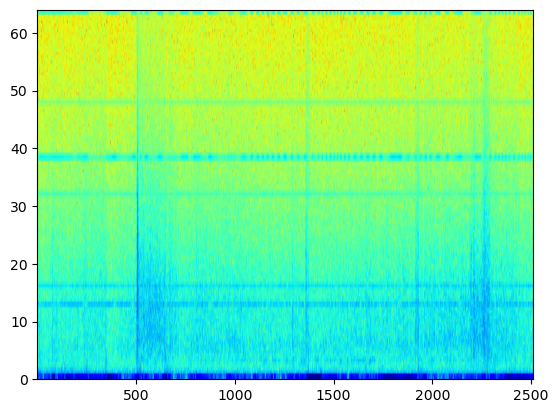

In [ ]:
# Spectrogram example (not resampled)
plt.specgram(raw_eeg[:][0][0], Fs=128, cmap='jet_r')
plt.show()